In [1]:
import numpy as np
import os
# os.environ["JAX_LOG_COMPILES"] = "True"

import copy
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.constants import mu_0
%matplotlib inline
import sys
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../'))
import functools

import jax
import jax.numpy as jnp
from jax import jit, jacfwd

from netCDF4 import Dataset
import h5py

from desc.backend import put
from desc.basis import FourierZernikeBasis, DoubleFourierSeries, FourierSeries
# from desc.boundary_conditions import get_boundary_condition, LCFSConstraint
from desc.equilibrium import EquilibriaFamily, Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, Grid, QuadratureGrid
from desc.io import InputReader, load
# from desc.objective_funs import get_objective_function, ForceErrorNodes
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_surfaces, plot_comparison
from desc.transform import Transform
from desc.vmec import VMECIO
from desc.derivatives import Derivative
from desc.geometry import FourierRZToroidalSurface
from desc.profiles import SplineProfile
from desc.magnetic_fields import SplineMagneticField

from desc.utils import flatten_list
os.getcwd()

DESC version 0.4.13+610.g5905668.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 20.93 GB available memory


'/home/fouriest/SCHOOL/Princeton/PPPL/DESC_freeb'

To Try:

- include $n x [[B]] = \mu_0 K$ equation
- take $K$ from vmec, fix it and use in desc while optimizing boundary
- 

# Boundary conditions

$\mathbf{B} \cdot \mathbf{n} = 0$ on interface

$[[p + B^2/2 \mu_0 ]] = 0$  on interface

$\mathbf{n} \times [[\mathbf{B}]] = \mu_0 \mathbf{K}$  where $K$ is a surface current density. Because $B$ lies tangent to the surface, $K$ will as well. 

Inside the plasma, we have $\mathbf{B} = \mathbf{B}_{FB}$ where $\mathbf{B}_{FB}$ is the magnetic field from a fixed boundary equilibrium solution, which inherently satisfies $\mathbf{B}_{FB} \cdot \mathbf{n} = 0$ on the surface. This field is made of 2 components:

$\mathbf{B}_{FB} = \mathbf{B}_{plasma} + \mathbf{B}_{fex}$

where $\mathbf{B}_{plasma}$ is the field due to the plasma and $\mathbf{B}_{fex}$ is a "fake" external field that makes $\mathbf{B}_{FB} \cdot \mathbf{n} = 0$ on the surface.

In reality, the magnetic field everywhere is due to 3 different sources: External coils, plasma, and surface currents at the plasma vacuum interface:

$\mathbf{B} = \mathbf{B}_{ex} + \mathbf{B}_{plasma} + \mathbf{B}_{K}$

If the boundary is correct, then we will have $\mathbf{B}_{fex} = \mathbf{B}_{ex} + \mathbf{B}_{K}$ everywhere in the plasma domain.



We can decompose $\mathbf{B}$ into normal and tangential components on the surface:

$\mathbf{B} = B_n \mathbf{n} + B_t \mathbf{t}$ where $\mathbf{t} = \mathbf{n} \times \mathbf{b}$

Then we have $B^2 = B_n^2 + B_t^2$. Since the normal field is continuous, the pressure balance reduces to

$[[p + B_t^2 /2\mu_0]] = 0$

and the jump in $B_t$ is due to the surface current $\mathbf{K}$

$\mu_0 \mathbf{K} = \mathbf{n} \times [[\mathbf{B}]] = \mathbf{n} \times [[B_n \mathbf{n} + B_t \mathbf{t}]] = \mathbf{n} \times [[B_t \mathbf{t}]]$

From pressure balance, we have

$p_{in} + B^2_{t,in}/2\mu_0 - p_{out} - B^2_{t,out}/2\mu_0 = 0$

$B^2_{t,out}/2\mu_0 = p_{in} - p_{out} + B^2_{t,in}/2\mu_0$

$B_{t,out} = \sqrt{2\mu_0 (p_{in} - p_{out}) + B^2_{t,in}}$

So then the sheet current is 

$\mu_0 \mathbf{K} = \mathbf{n} \times (B_{t,in} \mathbf{t}_{in} - B_{t,out} \mathbf{t}_{out})$

$\mu_0 \mathbf{K} = B_{in}(1 + \sqrt{2\mu_0 (p_{in} - p_{out}) + B^2_{t,in}}) \mathbf{n} \times (\mathbf{t}_{in} - \mathbf{t}_{out})$

Given a guess for $K$ we can find its effect on the magnetic pressure:

$\mu_0 \mathbf{n} \times \mathbf{K} = \mathbf{n} \times (\mathbf{n} \times [[\mathbf{B}]]) = (\mathbf{n} \cdot [[\mathbf{B}]]) \mathbf{n} - (\mathbf{n} \cdot \mathbf{n})[[\mathbf{B}]] = [[\mathbf{B}]]$ 

(since $\mathbf{n} \cdot \mathbf{B} = 0$ and $|\mathbf{n}| = 1$)

$\mu_0 \mathbf{n} \times \mathbf{K} = \mathbf{B}_{out} - \mathbf{B}_{in}$

$\mathbf{B}_{out} =  \mathbf{B}_{in} + \mathbf{n} \times \mu_0 \mathbf{K}$

$B_{out}^2 =  (\mathbf{B}_{in} + \mathbf{n} \times \mu_0 \mathbf{K})^2 = B_{in}^2 + \mu_0^2 K^2 + 2 \mathbf{B}_{in} \cdot (\mathbf{n} \times \mu_0 \mathbf{K})$


$\mathbf{B}_{plasma}$ can be found using a virtual casing principle:

$$\mathbf{B}_{plasma}(\mathbf{r}) = \frac{1}{4\pi} \int_D \frac{(\mathbf{n}(\mathbf{r}') \times \mathbf{B}(\mathbf{r}')_{FB}) \times (\mathbf{r} - \mathbf{r'})}{|\mathbf{r} - \mathbf{r'}|^3} + \left\{\begin{array}{lr}
        \mathbf{B}(\mathbf{r}), & \text{for } \mathbf{r} \in V\\
        \mathbf{B}(\mathbf{r})/2, & \text{for } \mathbf{r} \in D\\
        0, & \text{for } \mathbf{r} \not\in V,D
        \end{array}\right\}$$

$\mu_0 \mathbf{K} = \mathbf{n} \times [[\mathbf{B}]]$

$\mu_0 \nabla \cdot \mathbf{K} = \nabla \cdot (\mathbf{n} \times [[\mathbf{B}]])$ 

$\mu_0 \nabla \cdot \mathbf{K} = (\nabla \times \mathbf{n}) \cdot [[\mathbf{B}]] - \mathbf{n} \cdot (\nabla \times [[\mathbf{B}]])$

by construction, $\nabla \times \mathbf{n} = 0$

$\mu_0 \nabla \cdot \mathbf{K} = - \mathbf{n} \cdot (\nabla \times [[\mathbf{B}]])$

$\mu_0 \nabla \cdot \mathbf{K} = - \mathbf{n} \cdot (\nabla \times \mathbf{B}_{out} - \nabla \times \mathbf{B}_{in})$


Inside the plasma we have $\nabla \times \mathbf{B}_{in} = \mathbf{J}$, while outside, we have $\nabla \times \mathbf{B}_{out} = 0$

$\mu_0 \nabla \cdot \mathbf{K} = \mathbf{n} \cdot \mathbf{J}$

By the assumption of nested surfaces, we have $\mathbf{n} \cdot \mathbf{J} = 0$, thus giving

$\nabla \cdot \mathbf{K} = 0$


$\mathbf{K} = \mathbf{n} \times \nabla \Phi$

$\nabla \cdot \mathbf{K} = \nabla \cdot (\mathbf{n} \times \nabla \Phi)$

$\nabla \cdot (\mathbf{n} \times \nabla \Phi) = $

In [2]:
# from desc.objective_funs import ObjectiveFunction
from desc.compute import compute_contravariant_basis, compute_contravariant_magnetic_field, compute_pressure
from desc.utils import unpack_state
from desc.geometry.utils import rpz2xyz, rpz2xyz_vec, xyz2rpz_vec, rotation_matrix

@jax.jit  
def biot_loop(re, rs, J, dV):
    """
    
    Parameters
    ----------
    re : ndarray, shape(n_eval_pts, 3)
        evaluation points
    rs : ndarray, shape(n_src_pts, 3)
        source points
    J : ndarray, shape(n_src_pts, 3)
        current density vector at source points
    dV : ndarray, shape(n_src_pts)
        volume element at source points
    """
    re, rs, J, dV = map(jnp.asarray, (re, rs, J, dV))
    assert J.shape == rs.shape
    JdV = J * dV[:, None]
    B = jnp.zeros_like(re)
    def body(i, B):
        r = re - rs[i,:]
        num = jnp.cross(JdV[i,:], r, axis=-1)
        den = jnp.linalg.norm(r, axis=-1)**3
        B = B + jnp.where(den[:,None]==0, 0, num/den[:,None])
        return B
    return 1e-7 * jax.lax.fori_loop(0, J.shape[0], body, B)

@jax.jit
def biot_loop_periods(re, rs, J, dV, NFP):
    
    dphi = 2*np.pi/NFP
    R = rotation_matrix([0,0,1], dphi)
    B = jnp.zeros_like(re)
    Ri = jnp.eye(3)
    def body(i, B_Ri):
        B, Ri = B_Ri
        rsi = (Ri @ rs.T).T
        Ji = (Ri @ J.T).T
        B = B + biot_loop(re, rsi, Ji, dV)
        Ri = R @ Ri
        return B, Ri
    return jax.lax.fori_loop(0, NFP, body, (B,Ri))[0]


@jax.jit  
def vector_potential(re, rs, J, dV):
    """
    
    Parameters
    ----------
    re : ndarray, shape(n_eval_pts, 3)
        evaluation points
    rs : ndarray, shape(n_src_pts, 3)
        source points
    J : ndarray, shape(n_src_pts, 3)
        current density vector at source points
    dV : ndarray, shape(n_src_pts)
        volume element at source points
    """
    re, rs, J, dV = map(jnp.asarray, (re, rs, J, dV))
    assert J.shape == rs.shape
    JdV = J * dV[:, None]
    A = jnp.zeros_like(re)
    def body(i, A):
        r = re - rs[i,:]
        num = JdV[i,:]
        den = jnp.linalg.norm(r, axis=-1)
        A = A + jnp.where(den[:,None]==0, 0, num/den[:,None])
        return A
    return 1e-7 * jax.lax.fori_loop(0, J.shape[0], body, A)

@jax.jit
def vector_potential_periods(re, rs, J, dV, NFP):
    
    dphi = 2*np.pi/NFP
    R = rotation_matrix([0,0,1], dphi)
    A = jnp.zeros_like(re)
    Ri = jnp.eye(3)
    def body(i, A_Ri):
        A, Ri = A_Ri
        rsi = (Ri @ rs.T).T
        Ji = (Ri @ J.T).T
        A = A + vector_potential(re, rsi, Ji, dV)
        Ri = R @ Ri
        return A, Ri
    return jax.lax.fori_loop(0, NFP, body, (A,Ri))[0]

@jax.jit
def B_from_A(re, rs, J, dV, NFP):

    @jax.vmap
    def inner(re):
        dA = jax.jacfwd(vector_potential_periods)(jnp.atleast_2d(re), rs, J, dV/NFP, NFP)    
        c = dA[0,:,0,:]
        Bx = c[2,1] - c[1,2]
        By = c[0,2] - c[2,0]
        Bz = c[1,0] - c[0,1]  
        return jnp.asarray([Bx, By, Bz])
    return inner(re)

In [3]:
from desc.objectives.objective_funs import _Objective
from desc.compute import compute_contravariant_basis, compute_contravariant_magnetic_field, compute_pressure
from desc.utils import unpack_state
from desc.geometry.utils import rpz2xyz, rpz2xyz_vec, xyz2rpz_vec, rotation_matrix

@jax.jit  
def biot_loop(re, rs, J, dV):
    """
    
    Parameters
    ----------
    re : ndarray, shape(n_eval_pts, 3)
        evaluation points
    rs : ndarray, shape(n_src_pts, 3)
        source points
    J : ndarray, shape(n_src_pts, 3)
        current density vector at source points
    dV : ndarray, shape(n_src_pts)
        volume element at source points
    """
    re, rs, J, dV = map(jnp.asarray, (re, rs, J, dV))
    assert J.shape == rs.shape
    JdV = J * dV[:, None]
    B = jnp.zeros_like(re)
    def body(i, B):
        r = re - rs[i,:]
        num = jnp.cross(JdV[i,:], r, axis=-1)
        den = jnp.linalg.norm(r, axis=-1)**3
        B = B + jnp.where(den[:,None]==0, 0, num/den[:,None])
        return B
    return 1e-7 * jax.lax.fori_loop(0, J.shape[0], body, B)

@jax.jit
def biot_loop_periods(re, rs, J, dV, NFP):
    
    dphi = 2*np.pi/NFP
    R = rotation_matrix([0,0,1], dphi)
    B = jnp.zeros_like(re)
    Ri = jnp.eye(3)
    def body(i, B_Ri):
        B, Ri = B_Ri
        rsi = (Ri @ rs.T).T
        Ji = (Ri @ J.T).T
        B = B + biot_loop(re, rsi, Ji, dV)
        Ri = R @ Ri
        return B, Ri
    return jax.lax.fori_loop(0, NFP, body, (B,Ri))[0]

class BoundaryErrorBS(_Objective):

    _scalar = False
    _linear = False
    
    def __init__(self, ext_field, eq=None, target=0, weight=1, sgrid=None, egrid=None, name="B^2 Boundary"): 
        super().__init__(eq, target, weight, name)
        self.ext_field = ext_field
        self.sgrid=sgrid
        self.egrid=egrid
        self._callback_fmt = "Boundary Pressure Imbalance: {:10.3e} " + "Pa"
        
    def build(self, eq, use_jit=True, verbose=1):
        
        ntheta = 4*eq.M_grid+1
        nzeta = 4*eq.N_grid+1
        if self.egrid is None:
            self.egrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 
            self.egrid.nodes += np.array([0, np.pi/ntheta, np.pi/nzeta/eq.NFP])
        if self.sgrid is None:
            self.sgrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 

        self._dim_f = 2 * self.egrid.num_nodes
        self.NFP = eq.NFP
            
        self.eR_transform = Transform(self.egrid, eq.R_basis, derivs=1)
        self.eZ_transform = Transform(self.egrid, eq.Z_basis, derivs=1)
        self.eL_transform = Transform(self.egrid, eq.L_basis, derivs=1)

        self.sR_transform = Transform(self.sgrid, eq.R_basis, derivs=1)
        self.sZ_transform = Transform(self.sgrid, eq.Z_basis, derivs=1)
        self.sL_transform = Transform(self.sgrid, eq.L_basis, derivs=1)


        self.ep_profile = eq.pressure.copy()
        self.ei_profile = eq.iota.copy()
        self.sp_profile = eq.pressure.copy()
        self.si_profile = eq.iota.copy()
        self.ep_profile.grid = self.egrid
        self.ei_profile.grid = self.egrid
        self.sp_profile.grid = self.sgrid
        self.si_profile.grid = self.sgrid        
    
        self._check_dimensions()
        self._set_dimensions(eq)
        self._set_derivatives(use_jit=use_jit)
        self._built = True
    
    def compute(self, R_lmn, Z_lmn, L_lmn, p_l, i_l, Psi):

        Bdata_src = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, self.sR_transform, self.sZ_transform, 
                                   self.sL_transform, self.si_profile)
        ndata_src = compute_contravariant_basis(R_lmn, Z_lmn, self.sR_transform, self.sZ_transform)
        Bdata_eval = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, self.eR_transform, self.eZ_transform, 
                                   self.eL_transform, self.ei_profile)
        ndata_eval = compute_contravariant_basis(R_lmn, Z_lmn, self.eR_transform, self.eZ_transform)
        pdata_eval = compute_pressure(p_l, self.ep_profile)


        Bsrc = Bdata_src['B']
        Bsrc = rpz2xyz_vec(Bsrc, phi=self.sR_transform.grid.nodes[:,2])
        nsrc = ndata_src['e^rho'] / jnp.linalg.norm(ndata_src['e^rho'], axis=1)[:,np.newaxis]
        nsrc = rpz2xyz_vec(nsrc, phi=self.sR_transform.grid.nodes[:,2])
        J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0

        neval = ndata_eval['e^rho'] / jnp.linalg.norm(ndata_eval['e^rho'], axis=1)[:,np.newaxis]
        neval = rpz2xyz_vec(neval, phi=self.eR_transform.grid.nodes[:,2])

        rsrc = jnp.array([Bdata_src['R'], self.sR_transform.grid.nodes[:,2], Bdata_src['Z']]).T
        rsrc = rpz2xyz(rsrc)
        reval = jnp.array([Bdata_eval['R'], self.eR_transform.grid.nodes[:,2], Bdata_eval['Z']]).T
        reval = rpz2xyz(reval)

        dVeval = abs(Bdata_eval['|e_theta x e_zeta|'] * self.eR_transform.grid.weights)  # TODO: change to spacing
        dVsrc = abs(Bdata_src['|e_theta x e_zeta|'] * self.sR_transform.grid.weights)  # TODO: change to spacing
        
        B_tot = rpz2xyz_vec(Bdata_eval['B'], phi=self.eR_transform.grid.nodes[:,2])
        B_plasma = biot_loop_periods(reval, rsrc, J, dVsrc/self.NFP, self.NFP) #+ B_tot/2
        B_ex = self.ext_field.compute_magnetic_field(reval, basis="xyz")
        B_in = B_tot 
        B_out = B_ex + B_plasma
        Bsq_in = jnp.sum(B_in**2, axis=-1) + 2*mu_0*pdata_eval['p']
        Bsq_out = jnp.sum(B_out**2, axis=-1)
        Bsq_diff = (Bsq_in - Bsq_out)*dVeval
        Bn = jnp.sum(B_out*neval, axis=-1)*dVeval
        return jnp.concatenate([Bsq_diff, Bn])
    


In [4]:
veq = VMECIO.load("../educational_VMEC/test/wout_test_beta.vmec.nc", spectral_indexing="fringe")
veq.change_resolution(L=16, M=8, N=8, L_grid=20, M_grid=12, N_grid=12)

f = Dataset("../educational_VMEC/test/wout_test_beta.vmec.nc")
pres = np.asarray(f.variables['presf'])
sp = np.linspace(0,1,pres.size)
rp = np.sqrt(sp)
pressure = SplineProfile(pres, rp)

iot = np.asarray(f.variables['iotaf'])
si = np.linspace(0,1,iot.size)
ri = np.sqrt(si)
iota = SplineProfile(iot, ri)


veq.pressure = pressure
veq.iota = iota



In [5]:
veq.resolution_summary()
veq.solve(ftol=1e-2, xtol=1e-6, gtol=1e-6, maxiter=1000, verbose=3);

Spectral indexing: fringe
Spectral resolution (L,M,N)=(16,8,8)
Node pattern: jacobi
Node resolution (L,M,N)=(20,12,12)
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 548 ms
Timer: Objecive build = 558 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 7.01 sec
Timer: Jacobian compilation time = 18.0 sec
Timer: Total compilation time = 25.0 sec
Factorizing linear constraints
Timer: linear constraint factorize = 1.35 sec
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.6371e+06                                    1.86e+11    
       1              2         7.2053e+03      6.63e+06       6.61e-02       5.45e+09    
       2              3         3.4277e+03      3.78e+03       4.98e-02       3.29e+08    
       3              4         8.7807e+02      2.55e+03       4.51e-02       3.99e+08    
       4              6        

(<Figure size 1536x1152 with 6 Axes>,
 array([<AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>,
        <AxesSubplot:xlabel='$R ~(\\mathrm{m})$', ylabel='$Z ~(\\mathrm{m})$'>],
       dtype=object))

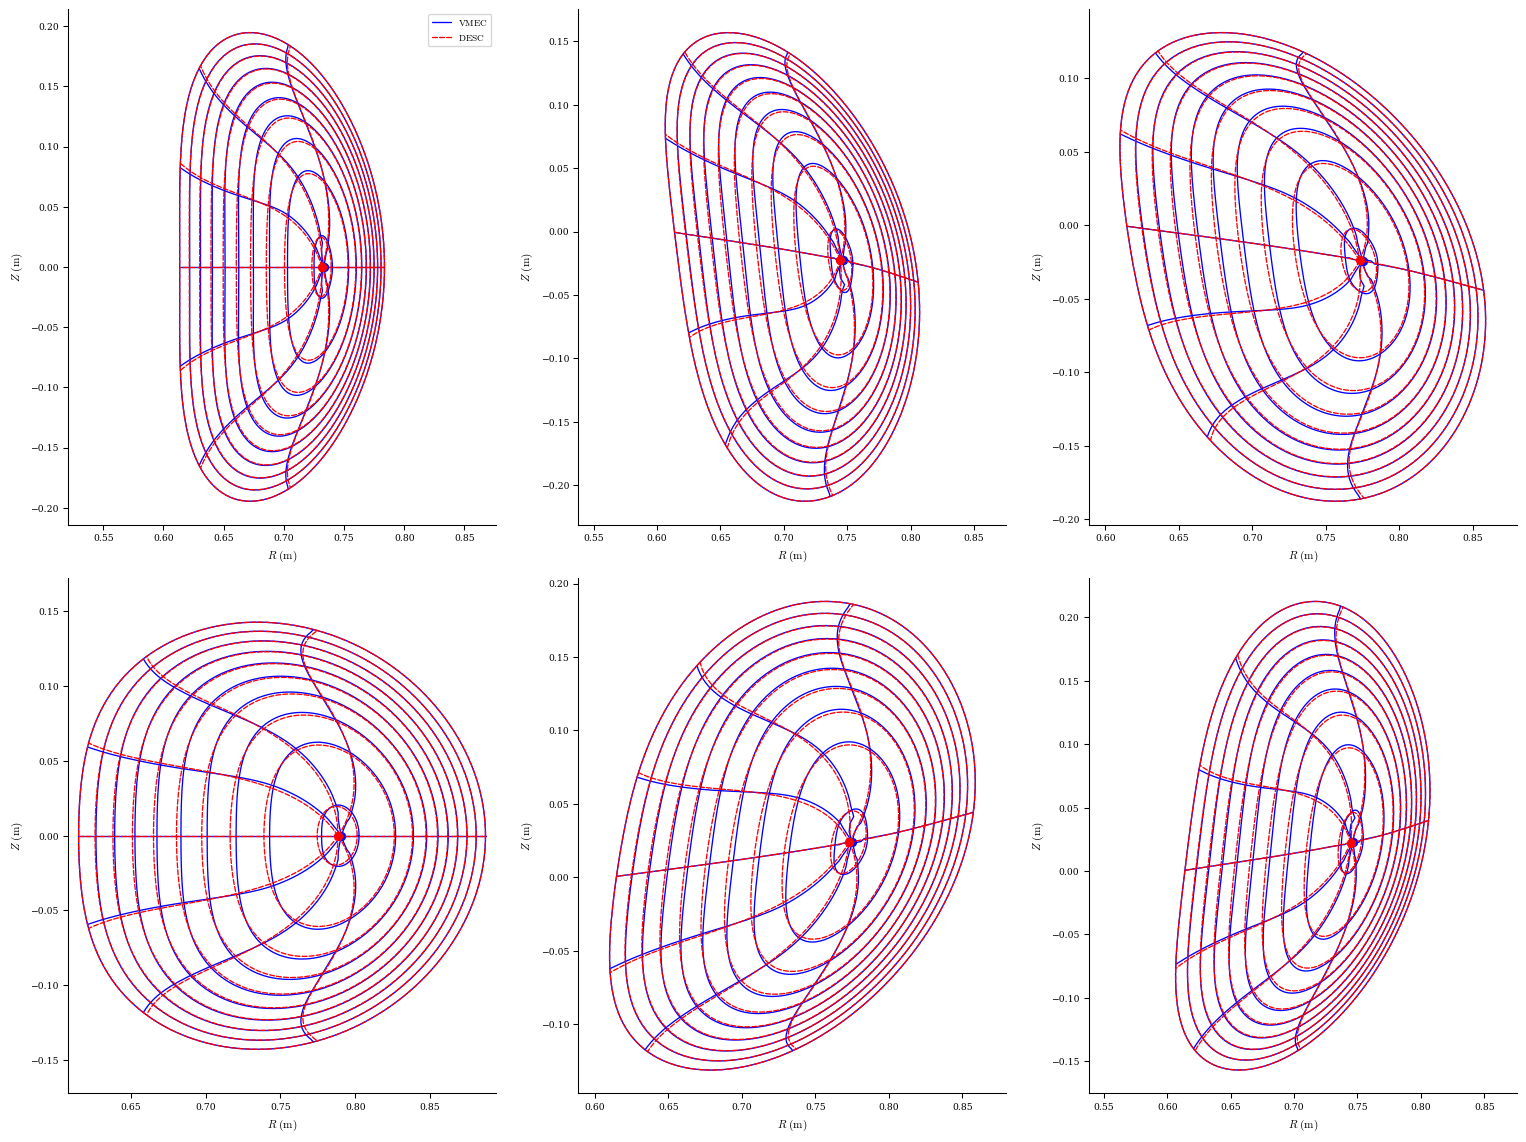

In [6]:
VMECIO.plot_vmec_comparison(veq, "../educational_VMEC/test/wout_test_beta.vmec.nc")

In [7]:
vacini = Dataset("../educational_VMEC/test/vac/vacin_test_iota.vmec_000000.nc", "r")

NFP     = int(vacini['nfp'][()])
mgrid = "tests/inputs/nestor/mgrid_test.nc"
extcur = vacini['extcur'][()]        
folder = os.getcwd()
mgridFilename = os.path.join(folder, mgrid)
ext_field = SplineMagneticField.from_mgrid(mgridFilename, extcur, extrap=True, period=(2*np.pi/NFP))


In [7]:
surf = veq.get_surface_at(1)
surf.change_resolution(M=1, N=0)
eq = Equilibrium(Psi=veq.Psi, pressure=veq.pressure, iota=veq.iota, spectral_indexing=veq.spectral_indexing, sym=veq.sym, NFP=veq.NFP)

In [8]:
eq.set_initial_guess(surf)
eq.surface = surf


In [9]:
eq.change_resolution(veq.L, veq.M, veq.N, veq.L_grid, veq.M_grid, veq.N_grid)
eq.solve(ftol=1e-2, verbose=3);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 230 ms
Timer: Objecive build = 240 ms
Compiling objective function and derivatives
Timer: Objective compilation time = 7.87 sec
Timer: Jacobian compilation time = 16.7 sec
Timer: Total compilation time = 24.5 sec
Factorizing linear constraints
Timer: linear constraint factorize = 109 ms
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1861e+06                                    1.30e+10    
       1              3         2.6359e+05      5.92e+06       1.21e-01       2.19e+09    
       2              4         5.0125e+02      2.63e+05       3.31e-02       3.33e+08    
       3              7         1.7670e+01      4.84e+02       9.65e-03       9.09e+07    
       4              9         2.5143e+00      1.52e+01       5.27e-03       1.86e+07    
       5             11         9.9112e-01      1.52e+00     

In [8]:
eq = veq.copy()

In [9]:
R_lmn, Z_lmn, L_lmn, p_l, i_l, Psi = eq.R_lmn, eq.Z_lmn, eq.L_lmn, eq.p_l, eq.i_l, eq.Psi

In [10]:
ntheta = 4*eq.M_grid+1
nzeta = 4*eq.N_grid+1

Begrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 
Begrid.nodes += np.array([0, np.pi/ntheta, np.pi/nzeta/eq.NFP])
BeR_transform = Transform(Begrid, eq.R_basis, derivs=1)
BeZ_transform = Transform(Begrid, eq.Z_basis, derivs=1)
BeL_transform = Transform(Begrid, eq.L_basis, derivs=1)

Bsgrid = LinearGrid(M=ntheta,N=nzeta, rho=1, NFP=eq.NFP) 
BsR_transform = Transform(Bsgrid, eq.R_basis, derivs=1)
BsZ_transform = Transform(Bsgrid, eq.Z_basis, derivs=1)
BsL_transform = Transform(Bsgrid, eq.L_basis, derivs=1)



Bep_profile = eq.pressure.copy()
Bei_profile = eq.iota.copy()
Bep_profile.grid = Begrid
Bei_profile.grid = Begrid
Bsp_profile = eq.pressure.copy()
Bsi_profile = eq.iota.copy()
Bsp_profile.grid = Bsgrid
Bsi_profile.grid = Bsgrid


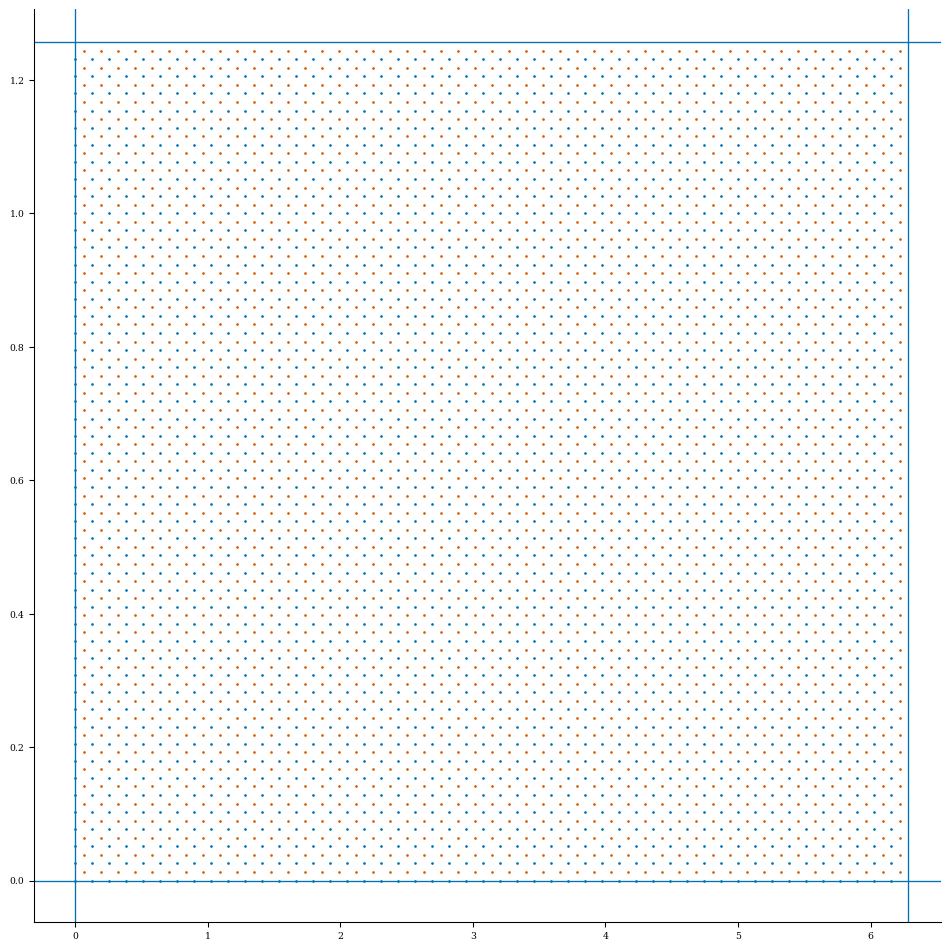

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(Bsgrid.nodes[:,1], Bsgrid.nodes[:,2], s=1)
ax.scatter(Begrid.nodes[:,1], Begrid.nodes[:,2], s=1)
ax.axhline(0)
ax.axhline(2*np.pi/eq.NFP)
ax.axvline(0)
ax.axvline(2*np.pi)

In [12]:
K_basis = DoubleFourierSeries(eq.M, eq.N, eq.NFP, sym="sin")
K_transform = Transform(Bsgrid, K_basis, derivs=1)
IGphi_mn = jnp.zeros(K_basis.num_modes+2)

In [153]:
from desc.compute._core import dot

Bdata_src = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, BsR_transform, BsZ_transform, 
                                   BsL_transform, Bsi_profile)
ndata_src = compute_contravariant_basis(R_lmn, Z_lmn, BsR_transform, BsZ_transform)
Bdata_eval = compute_contravariant_magnetic_field(R_lmn, Z_lmn, L_lmn, i_l, Psi, BeR_transform, BeZ_transform, 
                                   BeL_transform, Bei_profile)
ndata_eval = compute_contravariant_basis(R_lmn, Z_lmn, BeR_transform, BeZ_transform)
pdata_src = compute_pressure(p_l, Bsp_profile)


I = IGphi_mn[0]
G = IGphi_mn[1]
phi_mn = IGphi_mn[2:]

K_t = K_transform.transform(phi_mn, dt=1)[:,np.newaxis] + I/(2*np.pi)
K_z = K_transform.transform(phi_mn, dz=1)[:,np.newaxis] + G/(2*np.pi)
K = K_t*ndata_src['e^theta'] + K_z*ndata_src['e^zeta']
K = rpz2xyz_vec(K, phi=K_transform.grid.nodes[:,2])

Bsrc = Bdata_src['B']
Bsrc = rpz2xyz_vec(Bsrc, phi=BsR_transform.grid.nodes[:,2])
nsrc = ndata_src['e^rho'] / jnp.linalg.norm(ndata_src['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=BsR_transform.grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0

rsrc = jnp.array([Bdata_src['R'], BsR_transform.grid.nodes[:,2], Bdata_src['Z']]).T
rsrc = rpz2xyz(rsrc)
reval = jnp.array([Bdata_eval['R'], BeR_transform.grid.nodes[:,2], Bdata_eval['Z']]).T
reval = rpz2xyz(reval)

neval = ndata_eval['e^rho'] / jnp.linalg.norm(ndata_eval['e^rho'], axis=1)[:,np.newaxis]
neval = rpz2xyz_vec(neval, phi=BeR_transform.grid.nodes[:,2])

dVeval = abs(Bdata_eval['sqrt(g)'] * BeR_transform.grid.weights)  # TODO: change to spacing
dVsrc = abs(Bdata_src['|e_theta x e_zeta|'] * BsR_transform.grid.weights)  # TODO: change to spacing

Beval = rpz2xyz_vec(Bdata_eval['B'], phi=BeR_transform.grid.nodes[:,2])
B_plasma = biot_loop_periods(reval, rsrc, J, dVsrc/eq.NFP, eq.NFP) + Beval/2
B_sheet = biot_loop_periods(reval, rsrc, K, dVsrc/eq.NFP, eq.NFP)
B_ex = ext_field.compute_magnetic_field(reval, basis="xyz")

# dVsrc = jnp.sqrt(dVsrc / dVsrc.sum())
# dVeval = jnp.sqrt(dVeval / dVeval.sum())
B_in = Bsrc 
Bsq_in = jnp.sum(B_in**2, axis=-1) + 2*mu_0*pdata_src['p']
B_out = B_in + mu_0 * jnp.cross(nsrc, K)
Bsq_out = jnp.sum(B_out**2, axis=-1)
Bsq_diff = (Bsq_in - Bsq_out)*dVeval
B_err = dot(B_plasma + B_sheet + B_ex, neval)


In [155]:
dVeval.sum()

DeviceArray(0.49065233, dtype=float64)

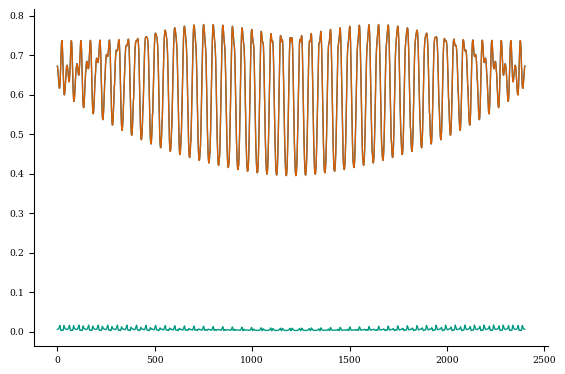

In [141]:
plt.plot(np.linalg.norm(Beval, axis=-1))
plt.plot(np.linalg.norm(B_ex, axis=-1))
plt.plot(np.linalg.norm(B_plasma, axis=-1))

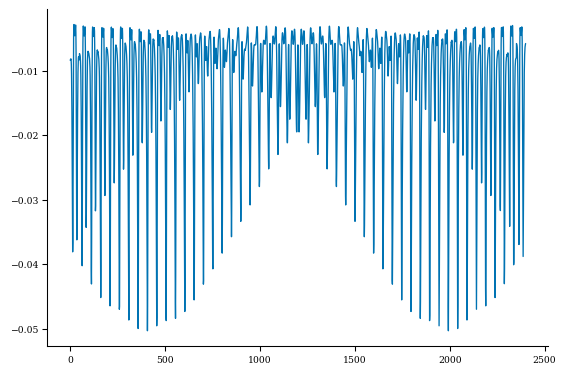

In [151]:
plt.plot( (np.linalg.norm(B_plasma + B_ex, axis=-1)**2 - np.linalg.norm(Beval, axis=-1)**2) / (np.linalg.norm(Beval, axis=-1)**2).mean())

In [156]:
from desc.compute._core import dot
@jax.jit
def sheet_objective(IGphi_mn):
    
    I = IGphi_mn[0] / mu_0
    G = IGphi_mn[1] / mu_0
    phi_mn = IGphi_mn[2:] / mu_0
    
    K_t = K_transform.transform(phi_mn, dt=1)[:,np.newaxis] + I/(2*np.pi)
    K_z = K_transform.transform(phi_mn, dz=1)[:,np.newaxis] + G/(2*np.pi)
    K = K_t*ndata_src['e_theta'] + K_z*ndata_src['e_zeta']
    K = rpz2xyz_vec(K, phi=K_transform.grid.nodes[:,2])

    Bsrc = Bdata_src['B']
    Bsrc = rpz2xyz_vec(Bsrc, phi=BsR_transform.grid.nodes[:,2])
    nsrc = ndata_src['e^rho'] / jnp.linalg.norm(ndata_src['e^rho'], axis=1)[:,np.newaxis]
    nsrc = rpz2xyz_vec(nsrc, phi=BsR_transform.grid.nodes[:,2])
    J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0

    rsrc = jnp.array([Bdata_src['R'], BsR_transform.grid.nodes[:,2], Bdata_src['Z']]).T
    rsrc = rpz2xyz(rsrc)
    reval = jnp.array([Bdata_eval['R'], BeR_transform.grid.nodes[:,2], Bdata_eval['Z']]).T
    reval = rpz2xyz(reval)

    neval = ndata_eval['e^rho'] / jnp.linalg.norm(ndata_eval['e^rho'], axis=1)[:,np.newaxis]
    neval= rpz2xyz_vec(neval, phi=BeR_transform.grid.nodes[:,2])

    dVeval = abs(Bdata_eval['|e_theta x e_zeta|'] * BeR_transform.grid.weights)  # TODO: change to spacing
    dVsrc = abs(Bdata_src['|e_theta x e_zeta|'] * BsR_transform.grid.weights)  # TODO: change to spacing

    Beval = rpz2xyz_vec(Bdata_eval['B'], phi=BeR_transform.grid.nodes[:,2])
    B_plasma = biot_loop_periods(reval, rsrc, J, dVsrc/eq.NFP, eq.NFP) + Beval/2
    B_sheet = biot_loop_periods(reval, rsrc, K, dVsrc/eq.NFP, eq.NFP)
    B_ex = ext_field.compute_magnetic_field(reval, basis="xyz")

    # dVsrc = jnp.sqrt(dVsrc / dVsrc.sum())
    # dVeval = jnp.sqrt(dVeval / dVeval.sum())

#     B_in = Bsrc
#     Bsq_in = jnp.sum(B_in**2, axis=-1) + 2*mu_0*pdata_eval['p']
#     B_out = B_in + mu_0 * jnp.cross(nsrc, K)
#     Bsq_out = jnp.sum(B_out**2, axis=-1)
#     Bsq_diff = (Bsq_in - Bsq_out)*dVsrc
#     Bn = dot(B_plasma + B_sheet + B_ex, neval)*dVeval
    
    
    B_in = Beval 
    B_out = B_ex + B_plasma + B_sheet
    Bsq_in = jnp.sum(B_in**2, axis=-1) + 2*mu_0*pdata_eval['p']
    Bsq_out = jnp.sum(B_out**2, axis=-1)
    Bsq_diff = (Bsq_in - Bsq_out)*dVeval
    Bn = jnp.sum(B_out*neval, axis=-1)*dVeval

    return jnp.concatenate([Bsq_diff, Bn])
    
jac = jax.jit(jax.jacfwd(sheet_objective))

In [157]:
dVsrc.sum()

DeviceArray(4.14984663, dtype=float64)

In [158]:
out = scipy.optimize.least_squares(sheet_objective, IGphi_mn, jac=jac, verbose=2, max_nfev=20)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4540e-07                                    1.17e-05    
       1              2         2.4871e-08      1.21e-07       3.05e-01       1.32e-07    
       2              3         2.4732e-08      1.39e-10       1.05e-02       8.71e-09    
`gtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.4540e-07, final cost 2.4732e-08, first-order optimality 8.71e-09.


In [159]:
out.x

array([ 2.80598126e-01,  8.25514821e-02, -9.73712243e-06,  2.55188260e-05,
       -2.30293512e-05,  4.46365104e-06,  1.33677179e-05, -5.33367397e-06,
       -1.87951749e-06,  6.09330588e-07,  8.75589277e-09,  1.43538955e-05,
       -4.78782521e-05,  5.03380298e-05,  6.69127034e-06, -1.67928797e-05,
       -1.02957292e-06,  1.27292748e-06, -1.99318729e-07, -1.27501962e-07,
       -1.92981327e-05,  9.47830776e-05, -5.96573528e-05, -2.89336876e-05,
        3.51978958e-06,  3.30840947e-06, -2.38589918e-06, -7.82002961e-07,
        9.63848269e-07,  4.53272240e-05, -1.53009446e-04,  5.22459550e-06,
        1.44971810e-05, -7.37431690e-07, -1.47389908e-05,  2.81959972e-06,
        1.58449069e-06, -2.09087867e-06, -1.29767281e-04,  1.13303447e-04,
       -5.73896291e-05, -3.75517466e-05, -3.13348333e-05,  2.31608792e-05,
       -3.24637925e-06, -1.02893866e-06, -5.20026642e-06,  1.36025906e-04,
       -1.39929780e-04, -1.73436283e-04, -2.91521920e-05,  1.65150379e-05,
       -5.18751727e-05,  

In [160]:
res = sheet_objective(out.x)


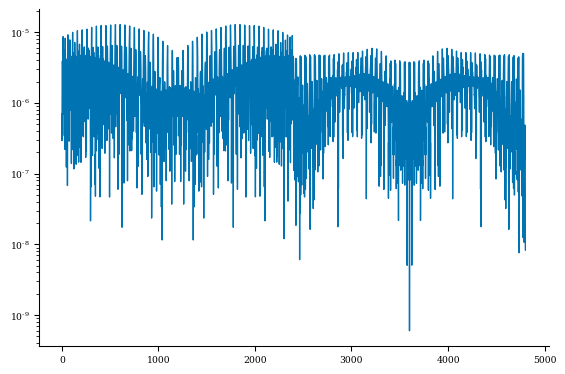

In [161]:
plt.semilogy(abs(res))

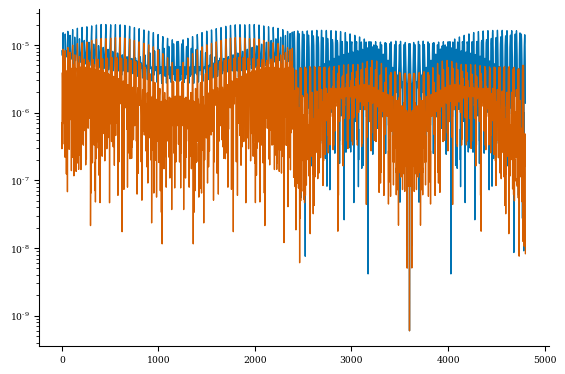

In [162]:
plt.semilogy(abs(sheet_objective(IGphi_mn)))
plt.semilogy(abs(res))

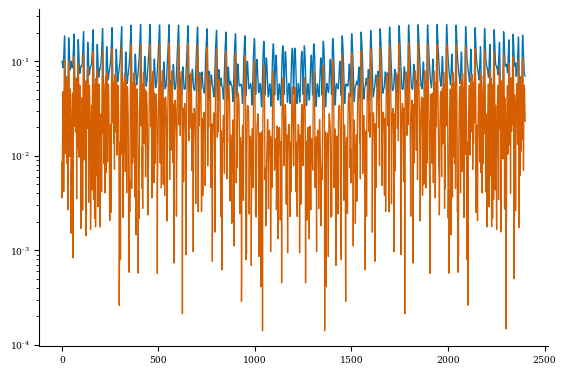

In [163]:
plt.semilogy(abs(sheet_objective(IGphi_mn))[:res.size//2] / np.mean(abs(np.linalg.norm(B_plasma + B_ex, axis=-1)**2)*dVeval))
plt.semilogy(abs(sheet_objective(out.x))[:res.size//2] / np.mean(abs(np.linalg.norm(B_plasma + B_ex, axis=-1)**2)*dVeval))

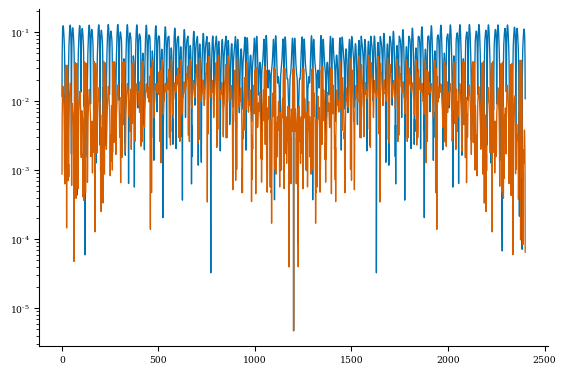

In [164]:
plt.semilogy(abs(sheet_objective(IGphi_mn))[res.size//2:] / np.mean(abs(np.linalg.norm(B_plasma + B_ex, axis=-1))*dVeval))
plt.semilogy(abs(sheet_objective(out.x))[res.size//2:] / np.mean(abs(np.linalg.norm(B_plasma + B_ex, axis=-1))*dVeval))

In [5]:
R_lmn = np.array([10, 1])
modes_R = np.array([[0, 0], [1, 0]])
Z_lmn = np.array([0, -1])
modes_Z = np.array([[0, 0], [-1, 0]])
surface = FourierRZToroidalSurface(R_lmn, Z_lmn, modes_R, modes_Z, NFP=1)
eq = Equilibrium(surface=surface, L=5, M=10, N=5, NFP=1, sym=False)

In [127]:
grid=QuadratureGrid(L=5, M=5, N=5, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [128]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
B = xyz2rpz_vec(biot_loop(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [129]:
B

DeviceArray([[ 2.03202029e-05, -4.03124364e-06,  7.30727099e-06],
             [ 1.61047863e-05,  2.66760803e-05, -6.52474548e-06],
             [ 1.71550673e-08, -1.04187038e-08,  2.55964399e-08],
             [ 1.58315188e-08, -3.62938512e-08,  7.19577773e-08],
             [-3.14096035e-05, -8.57616483e-05,  6.04339175e-05]],            dtype=float64)

In [130]:
grid=QuadratureGrid(L=10, M=10, N=10, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [131]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
B = xyz2rpz_vec(biot_loop(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [132]:
B

DeviceArray([[ 8.95114923e-06, -2.72323043e-06,  2.83108569e-06],
             [ 8.99814356e-06,  1.40668383e-05, -1.92432976e-06],
             [ 1.50188465e-08, -8.36666424e-09,  2.59775923e-08],
             [ 1.69014045e-08, -1.37395869e-08,  7.26667117e-08],
             [-1.51365356e-05, -5.15739803e-05,  3.35474259e-05]],            dtype=float64)

In [133]:
grid=QuadratureGrid(L=20, M=20, N=20, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [134]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
B = xyz2rpz_vec(biot_loop(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [135]:
B

DeviceArray([[ 5.76409337e-06, -2.96584970e-06,  1.41285708e-06],
             [ 5.07609738e-06,  8.43114041e-06, -7.90234660e-07],
             [ 1.49002242e-08, -8.51968329e-09,  2.59778357e-08],
             [ 1.65606477e-08, -1.40701741e-08,  7.26679253e-08],
             [-7.35997559e-06, -3.57986796e-05,  1.90013244e-05]],            dtype=float64)

In [136]:
grid=QuadratureGrid(L=30, M=30, N=30, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [137]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
B = xyz2rpz_vec(biot_loop(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [138]:
B

DeviceArray([[ 5.29056784e-06, -3.05863946e-06,  1.11879474e-06],
             [ 4.50111401e-06,  7.66734711e-06, -6.81411117e-07],
             [ 1.49002244e-08, -8.51968373e-09,  2.59778357e-08],
             [ 1.65606493e-08, -1.40701764e-08,  7.26679252e-08],
             [-5.46836512e-06, -3.33254890e-05,  1.29630205e-05]],            dtype=float64)

In [139]:
grid=QuadratureGrid(L=40, M=40, N=40, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [140]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
B = xyz2rpz_vec(biot_loop(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [141]:
B

DeviceArray([[ 5.22199083e-06, -3.07615501e-06,  1.06243677e-06],
             [ 4.42820365e-06,  7.56017753e-06, -6.70929113e-07],
             [ 1.49002244e-08, -8.51968373e-09,  2.59778357e-08],
             [ 1.65606493e-08, -1.40701764e-08,  7.26679252e-08],
             [-4.05302773e-06, -3.35442373e-05,  1.05318126e-05]],            dtype=float64)

In [12]:

from desc.geometry.utils import rpz2xyz_vec, rpz2xyz, xyz2rpz_vec

In [17]:
grid=QuadratureGrid(L=5, M=5, N=5, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [18]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
A = xyz2rpz_vec(vector_potential(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [19]:
A

DeviceArray([[-3.48435754e-17, -8.58280665e-34,  5.91663745e-02],
             [-2.63178811e-17, -6.09884143e-33,  6.24002847e-02],
             [ 9.18865182e-34,  5.71513949e-33,  3.53774777e-02],
             [-8.05774083e-33, -9.96615313e-33,  5.00627356e-02],
             [-1.14185366e-16, -6.37147176e-33,  1.29079558e-01]],            dtype=float64)

In [26]:
dA = jax.jacfwd(vector_potential)
dA(re, rsxyz, Jxyz, dV).sum(axis=(1,2,3))

DeviceArray([-1.48840956e-02, -1.55446189e-02, -1.77109191e-03,
             -3.46395544e-18, -2.00866799e-03], dtype=float64)

In [145]:
grid=QuadratureGrid(L=10, M=10, N=10, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [146]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
A = xyz2rpz_vec(vector_potential(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [147]:
A

DeviceArray([[ 3.93938271e-07, -7.25883361e-07,  1.25584821e-05],
             [-1.72123499e-05,  5.05438928e-06,  1.00598305e-05],
             [ 1.74550102e-07, -1.25648813e-07,  6.46302274e-06],
             [ 3.79658002e-07, -1.70638819e-07,  8.70097792e-06],
             [ 7.28942995e-07, -1.52330666e-07,  1.27725661e-05]],            dtype=float64)

In [148]:
grid=QuadratureGrid(L=20, M=20, N=20, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [149]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
A = xyz2rpz_vec(vector_potential(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [150]:
A

DeviceArray([[ 3.98175977e-07, -1.19391282e-07,  1.19806113e-05],
             [-1.47054191e-05,  3.30418491e-06,  1.00529314e-05],
             [ 1.75332129e-07, -1.25407498e-07,  6.46251696e-06],
             [ 3.80871241e-07, -1.70281438e-07,  8.70052515e-06],
             [ 6.55253160e-07, -1.76176836e-07,  1.21320077e-05]],            dtype=float64)

In [151]:
grid=QuadratureGrid(L=30, M=30, N=30, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

In [152]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
A = xyz2rpz_vec(vector_potential(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [153]:
A

DeviceArray([[ 3.98271109e-07, -4.30583914e-08,  1.19355839e-05],
             [-1.45146773e-05,  3.15871792e-06,  1.00553693e-05],
             [ 1.75332125e-07, -1.25407504e-07,  6.46251688e-06],
             [ 3.80871238e-07, -1.70281446e-07,  8.70052504e-06],
             [ 6.40579561e-07, -2.00262935e-07,  1.20528170e-05]],            dtype=float64)

In [2]:
grid=QuadratureGrid(L=40, M=40, N=40, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

NameError: name 'eq' is not defined

In [155]:
re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0], [10, 0, 0]])
A = xyz2rpz_vec(vector_potential(re, rsxyz, Jxyz, dV), phi=jnp.zeros(re.shape[0]))

In [156]:
A

DeviceArray([[ 3.98272595e-07, -3.29687790e-08,  1.19308818e-05],
             [-1.44965641e-05,  3.14621424e-06,  1.00556484e-05],
             [ 1.75332125e-07, -1.25407504e-07,  6.46251688e-06],
             [ 3.80871238e-07, -1.70281446e-07,  8.70052504e-06],
             [ 6.38903396e-07, -2.10705293e-07,  1.20380830e-05]],            dtype=float64)

In [284]:
grid=QuadratureGrid(L=40, M=40, N=40, NFP=1)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)
rs = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
J = data['J']
dV = (data['sqrt(g)']*grid.weights)

Jxyz = rpz2xyz_vec(J, phi=grid.nodes[:,2])
rsxyz = rpz2xyz(rs)

re = jnp.array([[12.,0.,0.], [10., 0., 2.,], [0., 0., 10.,], [0,0,0],])

print(B_from_A(re, rsxyz, Jxyz, dV/eq.NFP, eq.NFP))
print(biot_loop_periods(re, rsxyz, Jxyz, dV/eq.NFP, eq.NFP))
print(vector_potential_periods(re, rsxyz, Jxyz, dV/eq.NFP, eq.NFP))

[[ 5.22199083e-06 -3.07615501e-06  1.06243677e-06]
 [ 4.42820365e-06  7.56017753e-06 -6.70929113e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]]
[[ 5.22199083e-06 -3.07615501e-06  1.06243677e-06]
 [ 4.42820365e-06  7.56017753e-06 -6.70929113e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]]
[[ 3.98272595e-07 -3.29687790e-08  1.19308818e-05]
 [-1.44965641e-05  3.14621424e-06  1.00556484e-05]
 [ 1.75332125e-07 -1.25407504e-07  6.46251688e-06]
 [ 3.80871238e-07 -1.70281446e-07  8.70052504e-06]]


In [285]:
grid=LinearGrid(rho=1, M=101, N=101, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

print(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP))
print(B_from_A(re, rsrc, J, dVsrc/eq.NFP, eq.NFP))
print(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP))


[[ 5.18159165e-06  2.37152607e-05  1.05357645e-06]
 [ 4.43236429e-06  1.69950992e-05 -7.01662917e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]]
[[ 5.18159165e-06  2.37152607e-05  1.05357645e-06]
 [ 4.43236429e-06  1.69950992e-05 -7.01662917e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]]
[[ 2.13721717e-04 -4.16562746e-08  5.28028155e-02]
 [-7.63520551e-02  2.41818254e-05 -2.07765938e-02]
 [ 2.19407283e-06 -5.51813031e-08 -1.76600792e-02]
 [ 2.29289668e-05 -1.70532296e-07 -5.00541765e-02]]


In [320]:
bas = []
bps = []
aas = []
for m in [21,41,61,81,101,201,401]:

    grid=LinearGrid(rho=1, M=m, N=m, NFP=eq.NFP, axis=False, endpoint=True)
    egrid = LinearGrid(rho=0.9, M=21, N=21, NFP=eq.NFP, axis=False)
    egrid.nodes += np.array([0,np.pi/21,np.pi/21])
    data = eq.compute("J", grid=grid)
    data = eq.compute("e^rho", grid=grid, data=data)

    edata = eq.compute("B", grid=egrid)
    rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
    rsrc = rpz2xyz(rsrc)

    re = jnp.array([edata['R'], egrid.nodes[:,2], edata['Z']]).T
    re = rpz2xyz(re)
    
    Bsrc = data["B"]
    Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
    nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
    nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
    J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
    dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

    BA = xyz2rpz_vec(B_from_A(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0])) + edata['B']
    BP = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0])) + edata['B']
    A = xyz2rpz_vec(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
    bas.append(BA)
    bps.append(BP)
    aas.append(A)

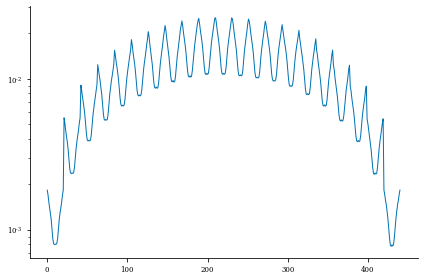

In [321]:
plt.semilogy(np.linalg.norm(aas[-1] - aas[-2], axis=1)/np.linalg.norm(aas[-1] , axis=1))

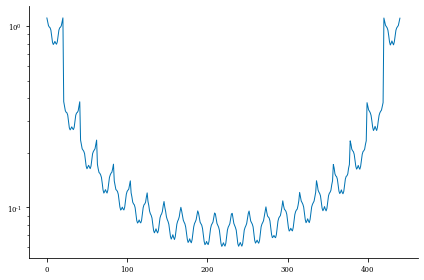

In [ ]:
plt.semilogy(np.linalg.norm(bas[-2] - bas[-1], axis=1)/np.linalg.norm(bas[-1] , axis=1))

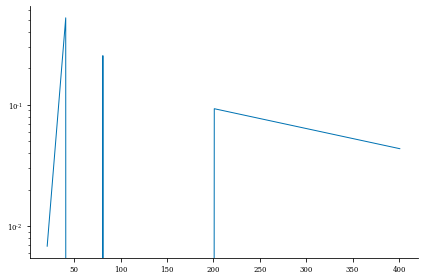

In [323]:
bas = np.array(bas)
plt.semilogy([21,41,61,81,101,201,401], abs(bas[:,0,0] - bas[-1,0,0]))


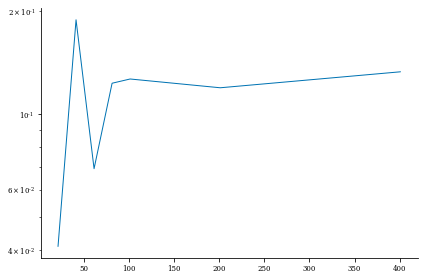

In [324]:
plt.semilogy([21,41,61,81,101,201,401], abs(bas[:,25,0] - bas[-1,25,0]))

In [173]:
grid=LinearGrid(rho=1, M=21, N=21, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

B_plasma = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
print(B_plasma)

[[ 3.94583836e-06  2.69446191e-02  3.05114030e-06]
 [ 2.86952114e-05  2.46292046e-02 -1.15681505e-05]
 [ 1.50774510e-08 -8.38654425e-09  2.59857649e-08]
 [ 1.71857259e-08 -1.41164040e-08  7.26685075e-08]
 [-1.09641910e-04 -5.12333655e-01  6.76981878e-06]]


In [174]:
grid=LinearGrid(rho=1, M=41, N=41, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

B_plasma = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
print(B_plasma)

[[ 3.74464232e-06  4.69448872e-03  1.49891305e-06]
 [ 8.31015576e-06  3.46264415e-03 -4.67753852e-06]
 [ 1.49002259e-08 -8.51968532e-09  2.59778357e-08]
 [ 1.65606520e-08 -1.40701801e-08  7.26679253e-08]
 [-1.06567064e-04 -3.47322398e-01  4.80384092e-06]]


In [175]:
grid=LinearGrid(rho=1, M=61, N=61, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

B_plasma = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
print(B_plasma)

[[ 4.74319411e-06  8.40286134e-04  1.14488860e-06]
 [ 5.03745279e-06  4.94954086e-04 -1.61205775e-06]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]
 [-1.14713885e-04 -3.22286005e-01  4.72614264e-06]]


In [176]:
grid=LinearGrid(rho=1, M=81, N=81, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

B_plasma = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
print(B_plasma)

[[ 5.08784085e-06  1.47692981e-04  1.06891420e-06]
 [ 4.51281439e-06  7.56466020e-05 -8.51654062e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]
 [-1.17679931e-04 -3.18283750e-01  4.78815458e-06]]


In [177]:
grid=LinearGrid(rho=1, M=101, N=101, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

B_plasma = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
print(B_plasma)

[[ 5.18159165e-06  2.37152607e-05  1.05357645e-06]
 [ 4.43236429e-06  1.69950992e-05 -7.01662917e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]
 [-1.18418362e-04 -3.17659004e-01  4.81577939e-06]]


In [178]:
grid=LinearGrid(rho=1, M=201, N=201, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

B_plasma = xyz2rpz_vec(biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))
print(B_plasma)

[[ 5.21066427e-06 -3.07523494e-06  1.04991652e-06]
 [ 4.41835521e-06  7.54344852e-06 -6.69620555e-07]
 [ 1.49002244e-08 -8.51968373e-09  2.59778357e-08]
 [ 1.65606493e-08 -1.40701764e-08  7.26679252e-08]
 [-1.18611583e-04 -3.17546522e-01  4.82610902e-06]]


In [179]:
B

DeviceArray([[ 5.22199083e-06, -3.07615501e-06,  1.06243677e-06],
             [ 4.42820365e-06,  7.56017753e-06, -6.70929113e-07],
             [ 1.49002244e-08, -8.51968373e-09,  2.59778357e-08],
             [ 1.65606493e-08, -1.40701764e-08,  7.26679252e-08],
             [-4.05302773e-06, -3.35442373e-05,  1.05318126e-05]],            dtype=float64)

In [190]:
grid=LinearGrid(rho=1, M=11, N=11, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

A_plasma = xyz2rpz_vec(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))

In [191]:
A_plasma

DeviceArray([[ 4.13204616e-04, -3.06535461e-06,  1.17636840e-01],
             [-1.33785803e-01,  5.71280275e-05, -1.82081936e-02],
             [ 2.47843910e-06, -9.46391728e-07, -1.76687518e-02],
             [ 2.38691030e-05, -6.88879719e-08, -5.00658759e-02],
             [ 2.64355739e-03, -1.79651719e-06, -1.96585916e-02]],            dtype=float64)

In [180]:
grid=LinearGrid(rho=1, M=21, N=21, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

A_plasma = xyz2rpz_vec(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))

In [181]:
A_plasma

DeviceArray([[ 2.61177567e-04, -8.19920293e-07,  6.81254241e-02],
             [-8.84738674e-02,  3.19078161e-05, -2.02237946e-02],
             [ 2.19294558e-06, -5.57187418e-08, -1.76600723e-02],
             [ 2.29274869e-05, -1.70939252e-07, -5.00541667e-02],
             [ 1.46829984e-03, -8.41723952e-07, -2.37829251e-02]],            dtype=float64)

In [233]:
grid=LinearGrid(rho=1, M=41, N=41, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

A_plasma = xyz2rpz_vec(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))

In [234]:
A_plasma

DeviceArray([[-2.93586615e-05, -3.54788094e-07,  4.56825760e-02],
             [ 2.07197819e-02, -1.01851747e-06,  4.25068559e-02],
             [ 3.96594180e-02, -3.89820487e-06,  3.32415076e-02],
             ...,
             [-5.23096017e-02,  1.62949934e-02,  1.83671414e-02],
             [-3.76228134e-02,  1.17128388e-02,  3.27994146e-02],
             [-1.96753597e-02,  6.11529925e-03,  4.20041021e-02]],            dtype=float64)

In [184]:
grid=LinearGrid(rho=1, M=101, N=101, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

A_plasma = xyz2rpz_vec(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))

In [185]:
A_plasma

DeviceArray([[ 2.13721717e-04, -4.16562746e-08,  5.28028155e-02],
             [-7.63520551e-02,  2.41818254e-05, -2.07765938e-02],
             [ 2.19407283e-06, -5.51813031e-08, -1.76600792e-02],
             [ 2.29289668e-05, -1.70532296e-07, -5.00541765e-02],
             [ 9.06008530e-04, -6.21655052e-07, -2.68918787e-02]],            dtype=float64)

In [186]:
grid=LinearGrid(rho=1, M=201, N=201, NFP=eq.NFP, axis=False)
data = eq.compute("J", grid=grid)
data = eq.compute("e^rho", grid=grid, data=data)

rsrc = jnp.array([data['R'], grid.nodes[:,2], data['Z']]).T
rsrc = rpz2xyz(rsrc)

Bsrc = data["B"]
Bsrc = rpz2xyz_vec(Bsrc, phi=grid.nodes[:,2])
nsrc = data['e^rho'] / jnp.linalg.norm(data['e^rho'], axis=1)[:,np.newaxis]
nsrc = rpz2xyz_vec(nsrc, phi=grid.nodes[:,2])
J = jnp.cross(nsrc, Bsrc, axis=1) / mu_0
dVsrc =  grid.weights * data['|e_theta x e_zeta|']  # TODO: change to spacing

A_plasma = xyz2rpz_vec(vector_potential_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP), phi=jnp.zeros(re.shape[0]))

In [187]:
A_plasma

DeviceArray([[ 2.13711272e-04, -4.12731443e-08,  5.27995507e-02],
             [-7.63510908e-02,  2.41807798e-05, -2.07766222e-02],
             [ 2.19407283e-06, -5.51813031e-08, -1.76600792e-02],
             [ 2.29289668e-05, -1.70532296e-07, -5.00541765e-02],
             [ 9.05687906e-04, -6.21703822e-07, -2.68943379e-02]],            dtype=float64)

In [188]:
A

DeviceArray([[ 3.98272595e-07, -3.29687790e-08,  1.19308818e-05],
             [-1.44965641e-05,  3.14621424e-06,  1.00556484e-05],
             [ 1.75332125e-07, -1.25407504e-07,  6.46251688e-06],
             [ 3.80871238e-07, -1.70281446e-07,  8.70052504e-06],
             [ 6.38903396e-07, -2.10705293e-07,  1.20380830e-05]],            dtype=float64)

In [ ]:
def 

In [254]:
re = jnp.array([[12., 0, 2.], [0, 0, 10]])

dA = jax.jacfwd(vector_potential_periods)(re, rsrc, J, dVsrc/eq.NFP, eq.NFP)

In [248]:
biot_loop_periods(re, rsrc, J, dVsrc/eq.NFP, eq.NFP)

DeviceArray([[-1.26931452e-06,  1.88389351e-04, -1.53198831e-07],
             [ 1.49002259e-08, -8.51968532e-09,  2.59778357e-08]],            dtype=float64)

In [255]:
c = dA[1,:,1,:]
Bx = c[2,1] - c[1,2]
By = c[0,2] - c[2,0]
Bz = c[1,0] - c[0,1]

In [256]:
print(Bx, By, Bz)

1.4900225942564455e-08 -8.519685324234731e-09 2.597783566728751e-08


In [264]:
B_from_A(re, rsrc, J, dVsrc/eq.NFP, eq.NFP)

DeviceArray([[-1.26931452e-06,  1.88389351e-04, -1.53198831e-07],
             [ 1.49002259e-08, -8.51968532e-09,  2.59778357e-08]],            dtype=float64)

In [352]:
grid1 = QuadratureGrid(20,20,20)
grid2 = QuadratureGrid(20,20,20)

In [353]:
%timeit np.all(grid1.nodes == grid2.nodes)

58.6 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [354]:
grid1.nodes.shape

(35301, 3)